In [1]:
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
print(parentdir)

/home/valdecar/Documents/projects/projectsNew/lab/hybriddomain/equation


##### Введение:

In [2]:
from equation import Equation

Некоторые поддерживаемые типы уравнений приведены ниже (Чтобы запустеть все доступные тесты нужно выполнить из папки equation: 
`python3 tests.py`):

In [3]:
eq_all = Equation("U'=(V(t-3.1)*U(t-3.1)+V(t-1.1)*U(t-3.1)+U(t-1.1))^3"
              + "+cos(U-c*D[U,{x,2}])")
eq_delay = Equation("U'=V(t-3.1)*U(t-3.1)+V(t-1.1)*U(t-3.1)")
eq_pow = Equation("U'=(V(t-3.1)+U)^3")
eq_diff = Equation("U'= U-c*D[U,{x,2}]")
eq_func = Equation("V + cos(x-c*D[U,{x,2}])")

eqs = [eq_all, eq_delay, eq_pow, eq_diff, eq_func]
for eq in eqs:
    eq.parse()

Чтобы произвести преобразование к cpp необходимо задать некоторые параметры. По умолчанию можно задать их используя set_default метод.

In [4]:
for eq in eqs:
    eq.set_default()

Чтобы узнать стандартные параметры проще всего глянуть ее исходник. Для этого в сдед ячейке использована jupyter команда `??e_all.set_default`.
Более точное описание см. ниже.

In [5]:
# uncomment next line to see source:
# ??eq_all.set_default

После того, как параметры заданы можно уже генерировать cpp строку:

In [6]:
for eq in eqs:
    print("\noriginal:")
    eq.show_original()
    print("\ncpp:")
    eq_diff.show_cpp()


original:
(U')=(V(t-3.1)*U(t-3.1)+V(t-1.1)*U(t-3.1)+U(t-1.1))^3+cos(U-c*D[U,{x,2}])

cpp:
source[0][idx + 0]=source[0][idx + 0]-params[2]*(DXM2 * (source[0][idx + 1 * Block0StrideX * Block0CELLSIZE + 0] - 2.0 * source[0][idx + 0 * Block0StrideX * Block0CELLSIZE + 0] + source[0][idx-1 * Block0StrideX * Block0CELLSIZE + 0]))

original:
(U')=V(t-3.1)*U(t-3.1)+V(t-1.1)*U(t-3.1)

cpp:
source[0][idx + 0]=source[0][idx + 0]-params[2]*(DXM2 * (source[0][idx + 1 * Block0StrideX * Block0CELLSIZE + 0] - 2.0 * source[0][idx + 0 * Block0StrideX * Block0CELLSIZE + 0] + source[0][idx-1 * Block0StrideX * Block0CELLSIZE + 0]))

original:
(U')=(V(t-3.1)+U)^3

cpp:
source[0][idx + 0]=source[0][idx + 0]-params[2]*(DXM2 * (source[0][idx + 1 * Block0StrideX * Block0CELLSIZE + 0] - 2.0 * source[0][idx + 0 * Block0StrideX * Block0CELLSIZE + 0] + source[0][idx-1 * Block0StrideX * Block0CELLSIZE + 0]))

original:
U'=U-c*D[U,{x,2}]

cpp:
source[0][idx + 0]=source[0][idx + 0]-params[2]*(DXM2 * (source[0][idx + 1

Этот результат можно получить в виде строки:

In [7]:
eq_diff.flatten('cpp')

'source[0][idx + 0]=source[0][idx + 0]-params[2]*(DXM2 * (source[0][idx + 1 * Block0StrideX * Block0CELLSIZE + 0] - 2.0 * source[0][idx + 0 * Block0StrideX * Block0CELLSIZE + 0] + source[0][idx-1 * Block0StrideX * Block0CELLSIZE + 0]))'

##### Описание cpp параметров

Вместо функции set_default можно установиь параметры явно:

In [8]:
sent = "U-c*D[U,{x,2}]"
eq_diff = Equation(sent)
eq_diff.parse()

eq_diff.set_dim(dim=2)
eq_diff.set_blockNumber(blockNumber=0)

eq_diff.set_vars_indexes(vars_to_indexes=[('U', 0), ('V', 1)])

coeffs_to_indexes = [('a', 0), ('b', 1), ('c', 2), ('r', 3)]
eq_diff.set_coeffs_indexes(coeffs_to_indexes=coeffs_to_indexes)

eq_diff.set_diff_type(diffType='pure',
                     diffMethod='special',
                     side=0, func="sin(idxX)")
eq_diff.show_cpp()

source[0][idx + 0]-params[2]*(2.0 * DXM2 * (source[0][idx + Block0StrideX * Block0CELLSIZE + 0] - source[0][idx + 0] - (sin(idxX)) * DX))


Только использование последнего метода отличает от умолчания. Если теперь поменять diffMethod, то результат измениться:

In [9]:
eq_diff.set_diff_type(diffType='pure',
                      diffMethod='common')
eq_diff.show_cpp()

source[0][idx + 0]-params[2]*(DXM2 * (source[0][idx + 1 * Block0StrideX * Block0CELLSIZE + 0] - 2.0 * source[0][idx + 0 * Block0StrideX * Block0CELLSIZE + 0] + source[0][idx-1 * Block0StrideX * Block0CELLSIZE + 0]))


##### Использование sympy

Для некоторых pde уравнений можно использовать sympy.pde методы. Для конвертации wolfram to sympy используется функция make_sympy (которой нужно знать размерность задачи через set_dim метод) 

In [15]:
e = Equation("U'=-a*(D[U,{x,1}])+U+sin(x)")
e.parse()
e.set_dim(dim=1)
e.make_sympy()
e.eq_sympy

∂                                  ∂          
──(U(t, x)) = U(t, x) + sin(x) - 2⋅──(U(t, x))
∂t                                 ∂x         


Eq(Derivative(U(t, x), t), U(t, x) + sin(x) - 2*Derivative(U(t, x), x))

После этого можно провести некоторый предварительный анализ pde:

In [16]:
e.classify_pde()

('1st_linear_constant_coeff', '1st_linear_constant_coeff_Integral')

In [17]:
e.pdsolve().rhs

2*t*exp(t/5 + 2*x/5) - x*exp(t/5 + 2*x/5) - sin(x)/5 - 2*cos(x)/5

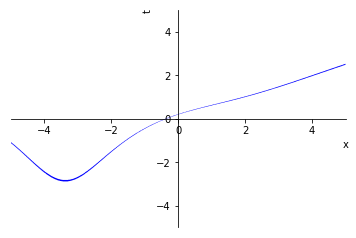

In [18]:
# slow:
e.plot_pde()

Пока это работает только для простых задач, но со временем их число может возрасти.